In [92]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from tasks.dsm_diffusion import DSMDiffusion
from tasks.direct_post import DirectPosterior
from tasks.metalearn import MetaLearningTask
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset
from torch2jax import j2t, t2j
import jax.numpy as jnp
import jax
from jax.scipy.special import rel_entr
from einops import repeat
from tqdm import tqdm
import random
import torch
import math
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
os.environ['LATENT_CONTROL_CKPT_DIR'] = '/network/scratch/l/leo.gagnon/latent_control_log/checkpoints'

In [93]:
task = MetaLearningTask.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/ewbu7sxt/last.ckpt"
)

Initializing dataset...Done!


In [90]:
task = DirectPosterior.load_from_checkpoint('/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/vva2z10q/last.ckpt')
task.cuda();

TypeError: MetaLearningTask.__init__() missing 1 required positional argument: 'cfg'

In [28]:
task.full_data.cfg.context_length = [10,10]

In [32]:
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = task.full_data.__getitems__([312]).values()

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:601: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [34]:
logits = task.forward(cond_input_ids=cond_input_ids, cond_tokens=cond_tokens, cond_mask=torch.logical_not(cond_ignore_mask))

In [80]:
probs = [torch.nn.functional.softmax(l, -1).squeeze() for l in logits]

In [43]:
i2l = j2t(task.base_task.full_data.index_to_latent)

In [81]:
probs = [math.prod([probs[i][i2l[j,i]] for i in range(len(probs))]) for j in range(len(i2l))]

In [82]:
probs = t2j(torch.stack(probs))

In [83]:
oracle = task.base_task.full_data.bayesian_oracle(jnp.arange(len(i2l)), t2j(cond_input_ids[0]))

In [84]:
oracle_post = jnp.exp(oracle['log_alpha_post'][-1])

In [86]:
rel_entr(oracle_post, probs).sum(-1), rel_entr(probs, oracle_post).sum(-1)

(Array(3.1940398, dtype=float32), Array(14.384678, dtype=float32))

In [ ]:
gru_out_cond = task.base_task.model.decoder(repeat(suffix, 'l -> b l', b=z_t.shape[0]), context_enc=z_t)
pp_cond = t2j(torch.softmax(gru_out_cond[...,:50], -1))

In [ ]:
gru_out_full = task.base_task.model.decoder(seq)
pp_full = t2j(torch.softmax(gru_out_full[:,:50],-1))

In [ ]:
kl_cond = jax.vmap(rel_entr)(oracle_pp[-len(suffix):], pp_cond.mean(0)).sum(-1)
kl_full = jax.vmap(rel_entr)(oracle_pp, pp_full).sum(-1)

In [ ]:
kl_full[len(prefix)-1]

Array(1.052768, dtype=float32)

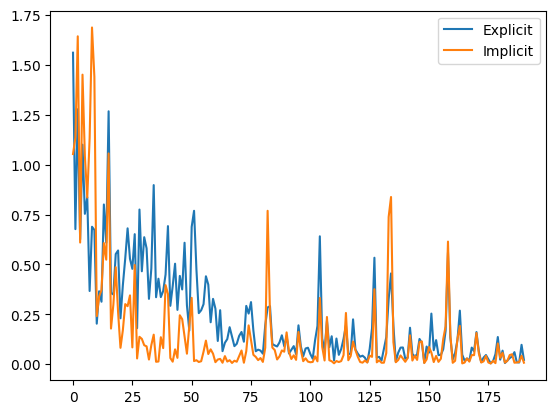

In [ ]:
plt.plot(jnp.concat([next_token_kl_cond[None],kl_cond]), label='Explicit')
plt.plot(kl_full[-len(suffix)-1:], label='Implicit')
plt.legend()

# Run the whole process for N_RUNS

In [ ]:
N_RUNS = 50

prefix_len = 10
pp_explicit = []
pp_implicit = []


for i in tqdm(range(N_RUNS)):
    seq = task.base_task.full_data[random.randint(0,len(dataset))]['input_ids'][0]
    prefix, suffix = torch.split(seq, [prefix_len, len(seq)-prefix_len], 0)

    z_t = task.diffusion_prior.sample(1024, cond=prefix[None], cond_mask=torch.ones_like(prefix, dtype=bool)[None], cls_free_guidance=1.0)
    if task.diffusion_prior.cfg.normalize_latent:
        z_t = task.diffusion_prior.unnormalize_latent(z_t)

    
    gru_out_full = task.base_task.model.decoder(seq)
    pp_full = t2j(torch.softmax(gru_out_full[:,:50],-1))

    oracle = task.base_task.full_data.bayesian_oracle(jnp.arange(len(dataset)), t2j(seq))
    oracle_pp = oracle['post_pred'][1:]

    next_token_pp = torch.softmax(task.base_task.model.decoder.lm_head(z_t[:,-1])[:,:50],-1)
    next_token_pp = t2j(next_token_pp)

    next_token_kl_cond = rel_entr(oracle_pp[len(prefix)-1], next_token_pp.mean(0)).sum()
    next_token_kl_full = rel_entr(oracle_pp[len(prefix)-1], pp_full[len(prefix)-1]).sum()
    
    pp_explicit.append(next_token_kl_cond)
    pp_implicit.append(next_token_kl_full)

  0%|          | 0/50 [00:00<?, ?it/s]/home/mila/l/leo.gagnon/latent_control/data/hmm.py:608: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:06<05:21,  6.56s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

  4%|▍         | 2/50 [00:12<05:08,  6.42s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:19<05:01,  6.41s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

  8%|▊         | 4/50 [00:25<04:55,  6.43s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 10%|█         | 5/50 [00:32<04:50,  6.46s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 12%|█▏        | 6/50 [00:38<04:45,  6.48s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 14%|█▍        | 7/50 [00:45<04:38,  6.48s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 16%|█▌        | 8/50 [00:51<04:32,  6.48s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 18%|█▊        | 9/50 [00:58<04:26,  6.49s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 20%|██        | 10/50 [01:04<04:18,  6.46s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 22%|██▏       | 11/50 [01:11<04:12,  6.47s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 24%|██▍       | 12/50 [01:17<04:06,  6.49s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 26%|██▌       | 13/50 [01:24<04:00,  6.51s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 28%|██▊       | 14/50 [01:30<03:55,  6.54s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 30%|███       | 15/50 [01:37<03:47,  6.50s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 32%|███▏      | 16/50 [01:43<03:40,  6.49s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 34%|███▍      | 17/50 [01:50<03:34,  6.50s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 36%|███▌      | 18/50 [01:56<03:28,  6.52s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 38%|███▊      | 19/50 [02:03<03:22,  6.52s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 40%|████      | 20/50 [02:09<03:16,  6.54s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 42%|████▏     | 21/50 [02:16<03:11,  6.61s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 44%|████▍     | 22/50 [02:23<03:04,  6.57s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [02:29<02:56,  6.53s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 48%|████▊     | 24/50 [02:36<02:49,  6.52s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 50%|█████     | 25/50 [02:42<02:43,  6.53s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 52%|█████▏    | 26/50 [02:49<02:37,  6.56s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 54%|█████▍    | 27/50 [02:55<02:31,  6.58s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 56%|█████▌    | 28/50 [03:02<02:24,  6.57s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 58%|█████▊    | 29/50 [03:09<02:18,  6.57s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 60%|██████    | 30/50 [03:15<02:11,  6.59s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 62%|██████▏   | 31/50 [03:22<02:05,  6.60s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 64%|██████▍   | 32/50 [03:28<01:58,  6.56s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [03:35<01:51,  6.54s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 68%|██████▊   | 34/50 [03:41<01:45,  6.57s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 70%|███████   | 35/50 [03:48<01:38,  6.58s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [03:55<01:32,  6.59s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 74%|███████▍  | 37/50 [04:01<01:25,  6.58s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 76%|███████▌  | 38/50 [04:08<01:19,  6.59s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 78%|███████▊  | 39/50 [04:14<01:12,  6.61s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 80%|████████  | 40/50 [04:21<01:05,  6.58s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 82%|████████▏ | 41/50 [04:27<00:59,  6.57s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 84%|████████▍ | 42/50 [04:34<00:52,  6.60s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 86%|████████▌ | 43/50 [04:41<00:46,  6.58s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 88%|████████▊ | 44/50 [04:47<00:39,  6.59s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 90%|█████████ | 45/50 [04:54<00:33,  6.61s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 92%|█████████▏| 46/50 [05:01<00:26,  6.60s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 94%|█████████▍| 47/50 [05:07<00:19,  6.56s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 96%|█████████▌| 48/50 [05:14<00:13,  6.55s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

 98%|█████████▊| 49/50 [05:20<00:06,  6.56s/it]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 50/50 [05:27<00:00,  6.54s/it]


In [ ]:
pp_explicit_ = jnp.stack(pp_explicit)
pp_implicit_ = jnp.stack(pp_implicit)

In [ ]:
pp_explicit_.std(0)

Array(0.4530168, dtype=float32)

In [ ]:
pp_implicit_.std()

Array(0.40835232, dtype=float32)

Text(0, 0.5, 'KL to oracle')

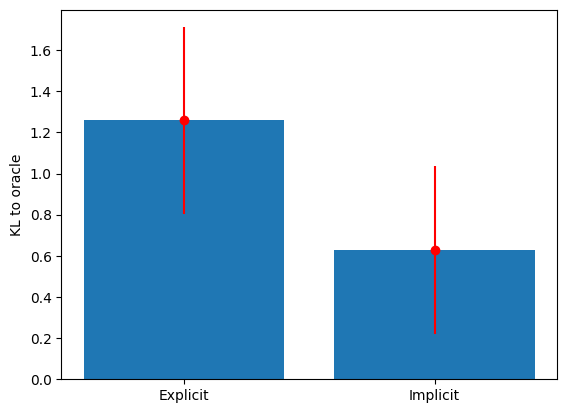

In [ ]:
plt.bar(['Explicit', 'Implicit'], [pp_explicit_.mean(), pp_implicit_.mean()])
plt.errorbar(['Explicit', 'Implicit'], [pp_explicit_.mean(0), pp_implicit_.mean(0)], yerr=[pp_explicit_.std(0), pp_implicit_.std(0)], fmt='o', color='r')
plt.ylabel('KL to oracle')

In [ ]:
y,binEdges = jnp.histogram(data,bins=10)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)
width      = 0.05
plt.bar(bincenters, y, width=width, color='r', yerr=menStd)
plt.show()


In [ ]:
pp_implicit.shape

(50,)

In [ ]:
xd_explicit = [e[0] for e in kl_cond_list]
xd_implicit = [e[-len(suffix):][0] for e in kl_full_list]

In [ ]:
xd_explicit = jnp.stack(xd_explicit)
xd_implicit = jnp.stack(xd_implicit)

In [ ]:
xd_implicit.mean(), xd_explicit.mean()

(Array(0.70209944, dtype=float32), Array(0.8820581, dtype=float32))

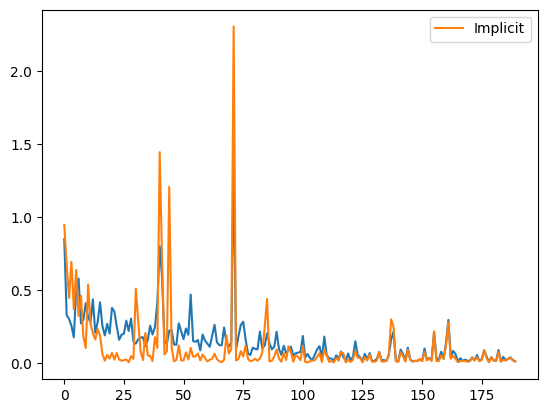

In [ ]:
i = 3
plt.plot(kl_cond_list[i])
plt.plot(kl_full_list[i][-len(suffix):], label='Implicit')
plt.legend()

Text(0.5, 1.0, 'KL(oracle, model) after suffix of length 10')

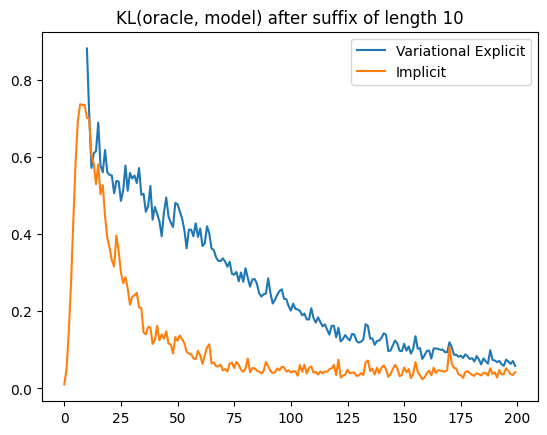

In [ ]:
plt.plot(jnp.arange(10,200), kl_cond, label='Variational Explicit')
plt.plot(jnp.arange(200), kl_full, label='Implicit')
plt.legend()
plt.title('KL(oracle, model) after suffix of length 10')